In [2]:
import numpy as np
import os
from wave import open as open_wave
import pandas as pd
%pylab inline
from  IPython.display import Audio
from scipy.stats import mode


Populating the interactive namespace from numpy and matplotlib


In [3]:
PATH = os.path.join(os.getcwd(),'..','..','gender-recognation','data','csv','waves.csv')

In [4]:
df = pd.read_csv(PATH)

In [5]:
def normalize(ys, amp=1.0):
    """Normalizes a wave array so the maximum amplitude is +amp or -amp.
    ys: wave array
    amp: max amplitude (pos or neg) in result
    returns: wave array
    """
    high, low = abs(max(ys)), abs(min(ys))
    return amp * ys / max(high, low)

In [6]:
class Wave:
    def __init__(self,ys,framerate):
        self.framerate = framerate
        self.ys = ys
        self.make_spectrum()
    @classmethod
    def read_wave(self,filename):
        """
        Reads a wave file.
        filename: string
        returns: Wave object
        """
        fp = open_wave(filename, 'r')

        nframes = fp.getnframes()
        sampwidth = np.int16
        framerate = fp.getframerate()

        z_str = fp.readframes(nframes)

        fp.close()
        ys = np.fromstring(z_str, dtype=sampwidth)

        ys = normalize(ys)
        return Wave(ys,framerate)
    
    def make_spectrum(self):
        """
        Computes the spectrum using FFT.
        hs: array of amplitudes (real)
        fs: array of frequencies
        framerate: frames per second
        full: boolean to indicate full or real FFT
        """
        n = len(self.ys)
        d = 1 / self.framerate


        self.hs = np.fft.rfft(self.ys)
        self.hs /= np.sqrt(len(self.hs))
        self.fs = np.fft.rfftfreq(n, d)
    
    def low_pass_filter(self, cutoff=280, factor=0):
        """
        Attenuate frequencies above the cutoff.
        cutoff: frequency in Hz
        factor: what to multiply the magnitude by
        """
        self.hs[abs(self.fs) > cutoff] *= factor
    
    @property
    def max_freq(self):
        """Returns the Nyquist frequency for this spectrum."""
        return self.framerate / 2

    @property
    def amps(self):
        """Returns a sequence of amplitudes (read-only property)."""
        return np.absolute(self.hs)

    @property
    def power(self):
        """Returns a sequence of powers (read-only property)."""
        return self.amps ** 2


In [7]:
p = df.path.iloc[0]
snd = Wave.read_wave(p)

/home/hadi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [8]:
snd.low_pass_filter()

In [9]:
np.abs(snd.hs).max()

2.0586715055663127

In [10]:
for x in df.path.iloc[:3].values:print(x)

/home/hadi/DataProjects/gender-recognition-by-voice/gender-recognation/data/raw/rjmunro-20090210-hhv.tgz/rjmunro-20090210-hhv/wav/b0228.wav
/home/hadi/DataProjects/gender-recognition-by-voice/gender-recognation/data/raw/rjmunro-20090210-hhv.tgz/rjmunro-20090210-hhv/wav/b0232.wav
/home/hadi/DataProjects/gender-recognition-by-voice/gender-recognation/data/raw/rjmunro-20090210-hhv.tgz/rjmunro-20090210-hhv/wav/b0236.wav


42000


/home/hadi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


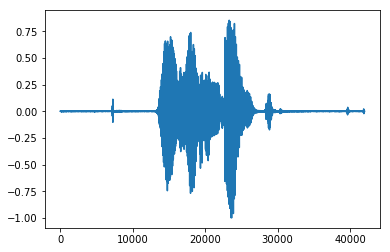

In [11]:
def plot_player(i):
    p = df.path.iloc[i]
    snd = Wave.read_wave(p)
    plot(snd.ys)
    print(len(snd.ys))
    audio = Audio(data=snd.ys, rate=snd.framerate)
    return audio

plot_player(0)

56000


/home/hadi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


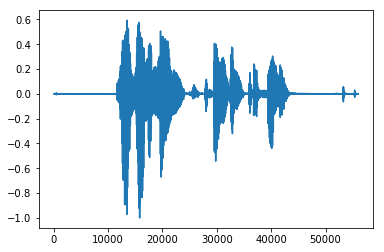

In [12]:
plot_player(9)

In [13]:
p = df.path.iloc[0]
snd = Wave.read_wave(p)
snd.low_pass_filter()


/home/hadi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


/home/hadi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


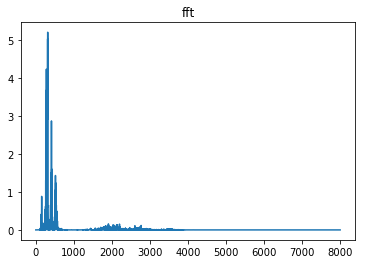

In [14]:
### power plot
#plot spectrum before LPF
snd = Wave.read_wave(p)
am, freq, framerate = snd.hs,snd.fs,snd.framerate
idx = np.argsort(freq)

plt.figure()
plt.plot(freq[idx], snd.power[idx])
plt.title('fft')

In [15]:
ys = np.fft.irfft(snd.hs)
audio = Audio(data=ys, rate=snd.framerate)
audio

/home/hadi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


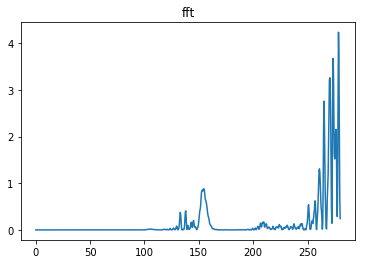

In [16]:
snd = Wave.read_wave(p)
cutoff = 280
snd.low_pass_filter(cutoff=cutoff)
am, freq, framerate = snd.hs,snd.fs,snd.framerate
idx = np.argsort(freq[freq <= cutoff])

plt.figure()
plt.plot(freq[idx], snd.power[idx] )
plt.title('fft')

In [17]:
ys = np.fft.irfft(snd.hs)
audio = Audio(data=ys, rate=snd.framerate)
audio

### Feature Extraction

###### ***Reference for features***
http://recherche.ircam.fr/equipes/analyse-synthese/peeters/ARTICLES/Peeters_2003_cuidadoaudiofeatures.pdf
###### ***``` Page : 13```***

#### Mean frequency (in kHz)

In [19]:
mean_f = sum((snd.amps*snd.fs))/(sum(snd.amps))
mean_f

220.55590555172407

In [20]:
def mean_f(amp, freq):
    return np.average(freq, weights =amp)
mean_f(snd.amps,snd.fs)

220.55590555172407

#### Standard deviation of frequency

In [42]:
moment_order_k(snd.amps,snd.fs, 1)

-5.150893803129086e-14

In [43]:
def moment_order_k(amp, freq, k):
    avg = mean_f(amp, freq)
    dev = amp * (freq - avg) ** k
    return dev.sum() / (amp.sum())

def var_f(amp, freq):
    return moment_order_k(amp, freq, 2)

def std_f(amp, freq):
    return np.sqrt(var_f(amp, freq))

std_f(snd.amps,snd.fs)

55.48677531827943

#### Median frequency (in kHz)

In [44]:
def weighted_percentile(data, percents, weights=None):
    ''' 
    percents in units of 1%
    weights specifies the frequency (count) of data.
    '''
    if weights is None:
        return np.percentile(data, percents)
    ind=np.argsort(data)
    d=data[ind]
    w=weights[ind]
    p=1.*w.cumsum()/w.sum()*100
    y=np.interp(percents, p, d)
    return y

In [45]:
weighted_percentile(snd.fs,70,weights=snd.amps)

265.77127384518417

In [46]:
def median_f(amp, freq):
    return weighted_percentile(freq,50,weights=amp)

median_f(snd.amps,snd.fs)

244.83870947713362

#### First quantile (in kHz)

In [47]:
def first_quantile_f(amp, freq):
    return weighted_percentile(freq,25,weights=amp)

first_quantile_f(snd.amps,snd.fs)

156.9879958076253

#### Third quantile (in kHz)

In [48]:
def third_quantile_f(amp, freq):
    return weighted_percentile(freq,75,weights=amp)

third_quantile_f(snd.amps,snd.fs)

269.4224825950283

#### Inter-quantile range (in kHz)

In [38]:
def inter_quantile_range_f(amp, freq):
    return third_quantile_f(amp, freq) - first_quantile_f(amp, freq)
inter_quantile_range_f(snd.amps,snd.fs)

112.43448678740302

####  Skewness

In [39]:
def skewness_f(amp, freq):
    m3 = moment_order_k(amp, freq, 3)
    sigma3 = np.power(std_f(amp, freq),3)
    return m3/sigma3
skewness_f(snd.amps,snd.fs)

-0.6151781104024144

#### Kurtosis

In [40]:
def kurtosis_f(amp, freq):
    m4 = moment_order_k(amp, freq, 4)
    sigma4 = np.power(std_f(amp, freq),4)
    return m4/sigma4
kurtosis_f(snd.amps,snd.fs)

1.8755998175145547

#### Mode frequency

In [371]:
mode(snd.amps)

ModeResult(mode=array([0.]), count=array([20265]))

In [377]:
def mode_f(amp, freq):
    return freq[amp.argmax()]
mode_f(snd.amps,snd.fs)

278.4761904761905

#### Peak frequency

In [41]:
def peak_f(power, freq):
    return freq[power.argmax()]
peak_f(snd.power,snd.fs)

278.4761904761905